# 1 模型选择、欠拟合和过拟合
### 通过多项式拟合来交互地探索这些概念

In [27]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 使用以下三阶多项式来生成训练和测试数据的标签
#### $y = 5 + 1.2x + 3.4\frac{x^2}{2!} + 5.6\frac{x^3}{3!} + \epsilon \quad where \quad \epsilon \sim\mathcal L(0, 0.1^2)$

In [28]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size = (n_train + n_test , 1))
np.random.shuffle(features)
ploy_features = np.power(features, np.arange(max_degree).reshape(1, -1))  # 生成多项式特征
for i in range(max_degree):
    ploy_features[:, i] /= math.gamma(i + 1)  # 求阶乘
labels = np.dot(ploy_features, true_w)  # 进行权重点积
labels += np.random.normal(scale = 0.1, size = labels.shape)  # 添加噪声数据

### 看一下前2个样本

In [29]:
# 将数据转换为张量
true_w, features, ploy_features, labels = [
    torch.tensor(x, dtype = torch.float32)
    for x in [true_w, features, ploy_features, labels]]

# 查看当前数据
features[:2], ploy_features[:2, :], labels[:2]

(tensor([[0.8124],
         [0.5452]]),
 tensor([[1.0000e+00, 8.1240e-01, 3.3000e-01, 8.9363e-02, 1.8149e-02, 2.9489e-03,
          3.9928e-04, 4.6340e-05, 4.7058e-06, 4.2477e-07, 3.4508e-08, 2.5486e-09,
          1.7254e-10, 1.0782e-11, 6.2569e-13, 3.3887e-14, 1.7206e-15, 8.2225e-17,
          3.7111e-18, 1.5868e-19],
         [1.0000e+00, 5.4522e-01, 1.4863e-01, 2.7013e-02, 3.6820e-03, 4.0150e-04,
          3.6485e-05, 2.8417e-06, 1.9367e-07, 1.1733e-08, 6.3970e-10, 3.1707e-11,
          1.4406e-12, 6.0419e-14, 2.3530e-15, 8.5527e-17, 2.9145e-18, 9.3472e-20,
          2.8313e-21, 8.1247e-23]]),
 tensor([5.4625, 5.3303]))

### 实现一个函数来评估模型在给定数据集上的损失

In [8]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

### 定义训练函数

In [20]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()  # 将模型设置为训练模式，forward和backward都需要进行
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), d2l.accuracy(y_hat, y), y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [18]:
def train(train_features, test_features, train_labels, test_labels,
         num_epochs = 400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias = False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), 
                                 batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                              batch_size, is_train = False)
    trainer = torch.optim.SGD(net.parameters(), lr = 0.01)
    animator = d2l.Animator(xlabel = 'epochs', ylabel = 'loss', yscale = 'log',
                            xlim = [1, num_epochs], ylim = [1e-3, 1e2], 
                            legend = ['train', 'test'])# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight', net[0].weight.data.numpy())
        

### 三阶多项式函数拟合（正态）

weight [[ 4.991476   1.1919799 -3.3952034  5.59477  ]]


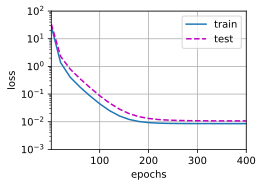

In [21]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(ploy_features[:n_train, :4], ploy_features[n_train:, :4], labels[:n_train], labels[n_train:])

### 线性函数拟合（欠拟合）

weight [[3.0729902 4.3638268]]


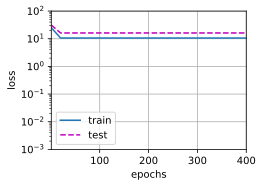

In [22]:
train(ploy_features[:n_train, :2], ploy_features[n_train:, :2], labels[:n_train], labels[n_train:])

### 高阶多项式函数拟合（过拟合）

weight [[ 4.9848022e+00  1.2384034e+00 -3.2570882e+00  5.3654437e+00
  -4.2354250e-01  1.0263039e+00 -1.5566482e-01 -1.4483848e-01
  -2.8290106e-02  5.3013344e-03  1.3330701e-01  1.3092275e-01
  -1.4599808e-01  1.2460120e-01 -1.6227746e-01 -3.3540457e-02
  -9.8911546e-02  6.4549692e-02  8.0387942e-02 -1.7270452e-01]]


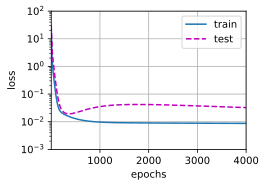

In [30]:
train(ploy_features[:n_train, :], ploy_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs = 4000)